Let's have a look at how to implement a decision tree in Python. Again, we need to first import the required packages and load the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, recall_score, precision_score, roc_curve
from sklearn.inspection import permutation_importance
pd.set_option('display.max_columns', 50) # Display up to 50 columns
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
import os.path

# Check if the file exists
if not os.path.isfile('data/card_transdata.csv'):

    print('Downloading dataset...')

    # Define the dataset to be downloaded
    zipurl = 'https://www.kaggle.com/api/v1/datasets/download/dhanushnarayananr/credit-card-fraud'

    # Download and unzip the dataset in the data folder
    with urlopen(zipurl) as zipresp:
        with ZipFile(BytesIO(zipresp.read())) as zfile:
            zfile.extractall('data')

    print('DONE!')

else:

    print('Dataset already downloaded!')

# Load the data
df = pd.read_csv('data/card_transdata.csv')

Dataset already downloaded!


This is the **dataset of credit card transactions** from [Kaggle.com](https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud/data) which we have used before. Recall that the target variable $y$ is `fraud`, which indicates whether the transaction is fraudulent or not. The other variables are the features $x$ of the transactions.

In [2]:
df.head(20)

distance_from_home  distance_from_last_transaction  \
0            57.877857                        0.311140   
1            10.829943                        0.175592   
2             5.091079                        0.805153   
3             2.247564                        5.600044   
4            44.190936                        0.566486   
5             5.586408                       13.261073   
6             3.724019                        0.956838   
7             4.848247                        0.320735   
8             0.876632                        2.503609   
9             8.839047                        2.970512   
10           14.263530                        0.158758   
11           13.592368                        0.240540   
12          765.282559                        0.371562   
13            2.131956                       56.372401   
14           13.955972                        0.271522   
15          179.665148                        0.120920   
16          114.519789                        0.707003   
17            3.589649                        6.247458   
18           11.085152                       34.661351   
19            6.194671                        1.142014   

    ratio_to_median_purchase_price  repeat_retailer  used_chip  \
0                         1.945940              1.0        1.0   
1                         1.294219              1.0        0.0   
2                         0.427715              1.0        0.0   
3                         0.362663              1.0        1.0   
4                         2.222767              1.0        1.0   
5                         0.064768              1.0        0.0   
6                         0.278465              1.0        0.0   
7                         1.273050              1.0        0.0   
8                         1.516999              0.0        0.0   
9                         2.361683              1.0        0.0   
10                        1.136102              1.0        1.0   
11                        1.370330              1.0        1.0   
12                        0.551245              1.0        1.0   
13                        6.358667              1.0        0.0   
14                        2.798901              1.0        0.0   
15                        0.535640              1.0        1.0   
16                        0.516990              1.0        0.0   
17                        1.846451              1.0        0.0   
18                        2.530758              1.0        0.0   
19                        0.307217              1.0        0.0   

    used_pin_number  online_order  fraud  
0               0.0           0.0    0.0  
1               0.0           0.0    0.0  
2               0.0           1.0    0.0  
3               0.0           1.0    0.0  
4               0.0           1.0    0.0  
5               0.0           0.0    0.0  
6               0.0           1.0    0.0  
7               1.0           0.0    0.0  
8               0.0           0.0    0.0  
9               0.0           1.0    0.0  
10              0.0           1.0    0.0  
11              0.0           1.0    0.0  
12              0.0           0.0    0.0  
13              0.0           1.0    1.0  
14              0.0           1.0    0.0  
15              1.0           1.0    0.0  
16              0.0           0.0    0.0  
17              0.0           0.0    0.0  
18              0.0           1.0    0.0  
19              0.0           0.0    0.0

In [3]:
df.describe()

distance_from_home  distance_from_last_transaction  \
count      1000000.000000                  1000000.000000   
mean            26.628792                        5.036519   
std             65.390784                       25.843093   
min              0.004874                        0.000118   
25%              3.878008                        0.296671   
50%              9.967760                        0.998650   
75%             25.743985                        3.355748   
max          10632.723672                    11851.104565   

       ratio_to_median_purchase_price  repeat_retailer       used_chip  \
count                  1000000.000000   1000000.000000  1000000.000000   
mean                         1.824182         0.881536        0.350399   
std                          2.799589         0.323157        0.477095   
min                          0.004399         0.000000        0.000000   
25%                          0.475673         1.000000        0.000000   
50%                          0.997717         1.000000        0.000000   
75%                          2.096370         1.000000        1.000000   
max                        267.802942         1.000000        1.000000   

       used_pin_number    online_order           fraud  
count   1000000.000000  1000000.000000  1000000.000000  
mean          0.100608        0.650552        0.087403  
std           0.300809        0.476796        0.282425  
min           0.000000        0.000000        0.000000  
25%           0.000000        0.000000        0.000000  
50%           0.000000        1.000000        0.000000  
75%           0.000000        1.000000        0.000000  
max           1.000000        1.000000        1.000000

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB


### Data Preprocessing

Since we have already explored the dataset in the previous notebook, we can skip that part and move directly to the data preprocessing. 

We will again split the data into training and test sets using the `train_test_split` function

In [5]:
X = df.drop('fraud', axis=1) # All variables except `fraud`
y = df['fraud'] # Only our fraud variables
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3, random_state = 42)

Then we can do the feature scaling to ensure our non-binary variables have mean zero and variance 1

In [6]:
def scale_features(scaler, df, col_names, only_transform=False):

    # Extract the features we want to scale
    features = df[col_names] 

    # Fit the scaler to the features and transform them
    if only_transform:
        features = scaler.transform(features.values)
    else:
        features = scaler.fit_transform(features.values)

    # Replace the original features with the scaled features
    df[col_names] = features

col_names = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price'] 
scaler = StandardScaler() 
scale_features(scaler, X_train, col_names)
scale_features(scaler, X_test, col_names, only_transform=True)

### Implementing a Decision Tree Classifier

We can now implement a decision tree model using the `DecisionTreeClassifier` class from the `sklearn.tree` module. Fitting the model to the data is almost the same as when we used logistic regression

In [7]:
clf_dt = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)

We can visualize the tree using the `plot_tree` function from the `sklearn.tree` module

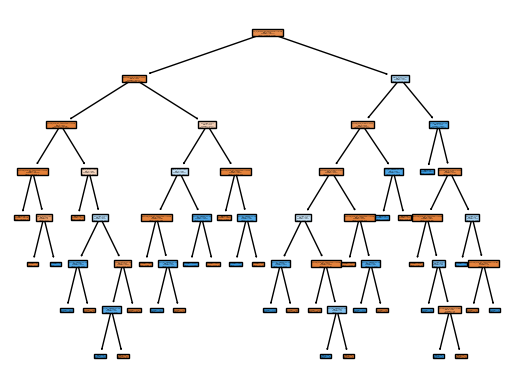

In [8]:
plot_tree(clf_dt, filled=True, feature_names = X_train.columns.to_list())
plt.show()

The tree is quite large and it's difficult to see details. Let's only look at the first level of the tree

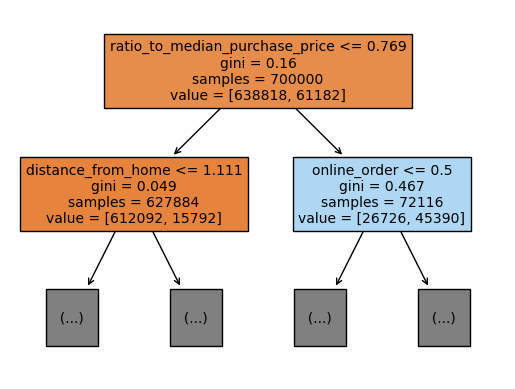

In [9]:
plot_tree(clf_dt, max_depth=1, filled=True, feature_names = X_train.columns.to_list(), fontsize=10)
plt.show()

Recall from the data exploration that `ratio_to_median_purchase_price` was highly correlated with fraud. The decision tree model seems to have picked up on this as well since the first split is based on this variable. Also, note that the order in which the variables are split can differ between different branches of the tree.

We can also make predictions using the model and evaluate its performance using the same functions as before

In [10]:
y_pred_dt = clf_dt.predict(X_test)
y_proba_dt = clf_dt.predict_proba(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred_dt)}")
print(f"Precision: {precision_score(y_test, y_pred_dt)}")
print(f"Recall: {recall_score(y_test, y_pred_dt)}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_dt[:, 1])}")

Accuracy: 0.9999833333333333
Precision: 0.9999237223493517
Recall: 0.999885587887571
ROC AUC: 0.999939141362689


The decision tree performs substantially better than the logistic regression. The ROC AUC score is much closer to the maximum value of 1 and we have an almost perfect classifier

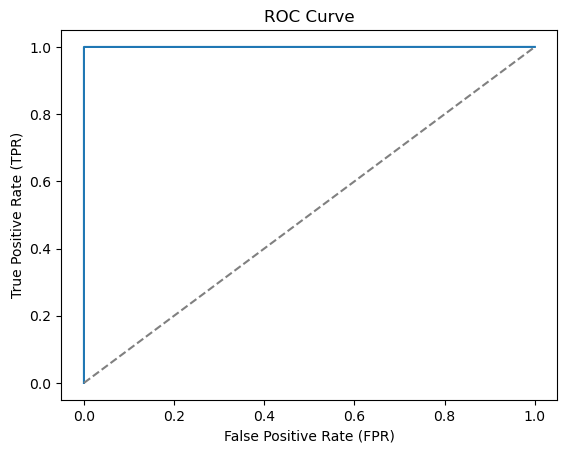

In [11]:
# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba_dt[:, 1])

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.show()

Let's also check the confusion matrix to see where we still make mistakes

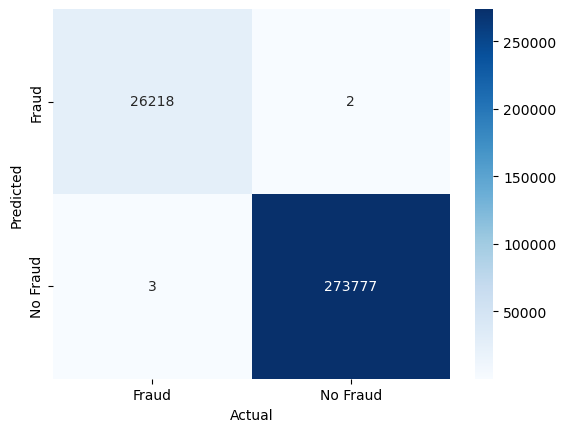

In [12]:
conf_mat = confusion_matrix(y_test, y_pred_dt, labels=[1, 0]).transpose() # Transpose the sklearn confusion matrix to match the convention in the lecture
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g', xticklabels=['Fraud', 'No Fraud'], yticklabels=['Fraud', 'No Fraud'])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

There are only 3 false negatives, i.e., fraudulent transactions that we did not detect. There are also 2 false positives, i.e., "false alarms", where non-fraudulent transactions were classified as fraudulent. The decision tree classifier is almost perfect which is a bit suspicious. We might have been lucky in the sense that the training and test sets were split in a way that the model performs very well. We should not expect this to be the case in general. It might be better to use cross-validation to get a more reliable estimate of the model's performance.


### Implementing a Random Forest Classifier

We can also implement a random forest model using the `RandomForestClassifier` class from the `sklearn.ensemble` module. Fitting the model to the data is almost the same as when we used logistic regression and decision trees

In [13]:
clf_rf = RandomForestClassifier(random_state = 0).fit(X_train, y_train)

Note that it takes a bit longer to train the Random Forest since we have to train many trees (the default setting is 100). We can also make predictions using the model and evaluate its performance using the same functions as before

In [14]:
y_pred_rf = clf_rf.predict(X_test)
y_proba_rf = clf_rf.predict_proba(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(f"Precision: {precision_score(y_test, y_pred_rf)}")
print(f"Recall: {recall_score(y_test, y_pred_rf)}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_rf[:, 1])}")

Accuracy: 0.9999833333333333
Precision: 1.0
Recall: 0.9998093131459517
ROC AUC: 0.9999999993035008


As expected, the Random Forest performs better than the Decision Tree in the metrics we have used. Now, let's also check the confusion matrix to see where we still make mistakes

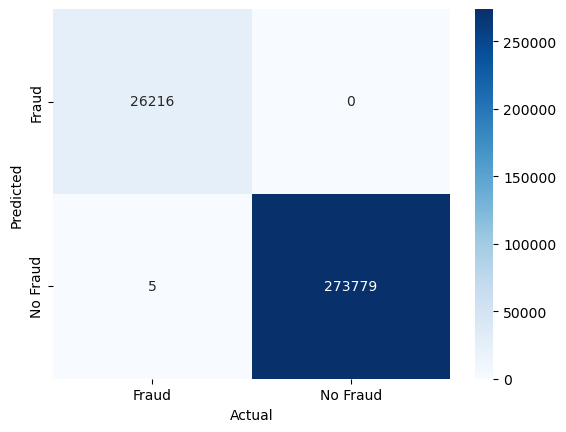

In [15]:
conf_mat = confusion_matrix(y_test, y_pred_rf, labels=[1, 0]).transpose() # Transpose the sklearn confusion matrix to match the convention in the lecture
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g', xticklabels=['Fraud', 'No Fraud'], yticklabels=['Fraud', 'No Fraud'])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

There are still some false negatives, but the number of false positives has decreased compared to the Decision Tree model. 


### Implementing a XGBoost Classifier

Let's also have a look at the XGBoost classifier. We can implement the model using the `XGBClassifier` class from the `xgboost` package. Fitting the model to the data is almost the same as when we used logistic regression, decision trees, and random forests, even though it is not part of the `sklearn` package. This is because the `xgboost` package is designed to work well with the `sklearn` package. Let's fit the model to the data

In [16]:
clf_xgb = XGBClassifier(random_state = 0).fit(X_train, y_train)

In [17]:
y_pred_xgb = clf_xgb.predict(X_test)
y_proba_xgb = clf_xgb.predict_proba(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb)}")
print(f"Precision: {precision_score(y_test, y_pred_xgb)}")
print(f"Recall: {recall_score(y_test, y_pred_xgb)}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba_xgb[:, 1])}")

Accuracy: 0.9983366666666667
Precision: 0.9893835616438356
Recall: 0.9916097784218756
ROC AUC: 0.999973496046352


Let's also check the confusion matrix to see where we still make mistakes

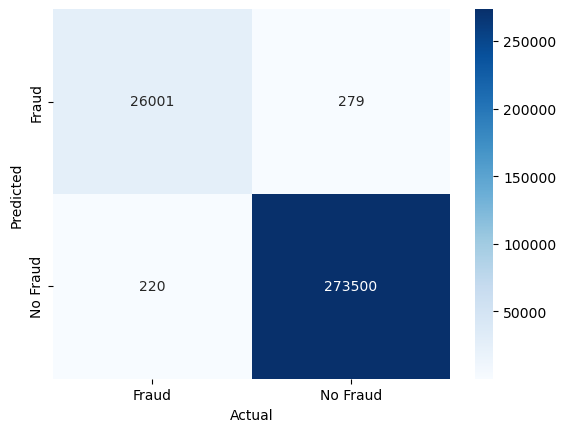

In [18]:
conf_mat = confusion_matrix(y_test, y_pred_xgb, labels=[1, 0]).transpose() # Transpose the sklearn confusion matrix to match the convention in the lecture
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g', xticklabels=['Fraud', 'No Fraud'], yticklabels=['Fraud', 'No Fraud'])
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()

The XGBoost model seems to perform a bit worse than the Random Forest model. There are more false negatives and false positives. However, the model is still very good at detecting fraudulent transactions and has a high ROC AUC score. Adjusting the hyperparameters of the model might improve its performance.


### Feature Importance

We can also look at the feature importance of each model. The feature importance is a measure of how much each feature contributes to the model's predictions. Let's start with the Decision Tree model

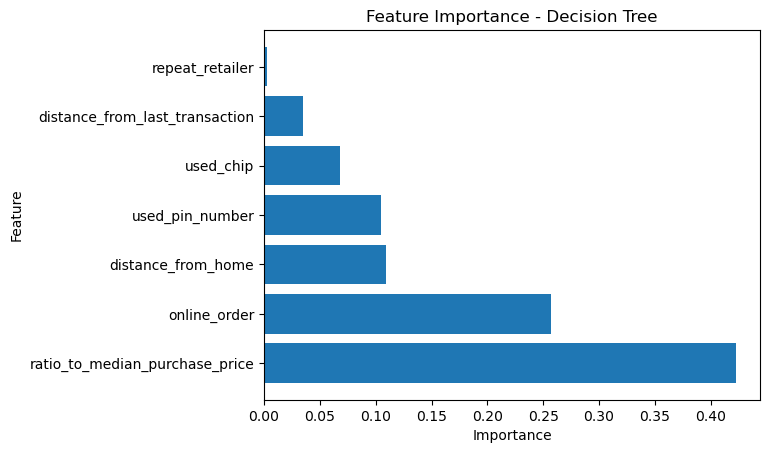

In [19]:
# Create a DataFrame with the feature importance
df_feature_importance_dt = pd.DataFrame({'Feature': X_train.columns, 'Importance': clf_dt.feature_importances_})
df_feature_importance_dt = df_feature_importance_dt.sort_values('Importance', ascending=False)

# Plot the feature importance
plt.barh(df_feature_importance_dt['Feature'], df_feature_importance_dt['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - Decision Tree')
plt.show()

This shows that the `ratio_to_median_purchase_price` is the most important feature for determining whether a transaction is fraudulent or not. Whether a transaction is online, is important as well.

Let's also look at the feature importance of the Random Forest model

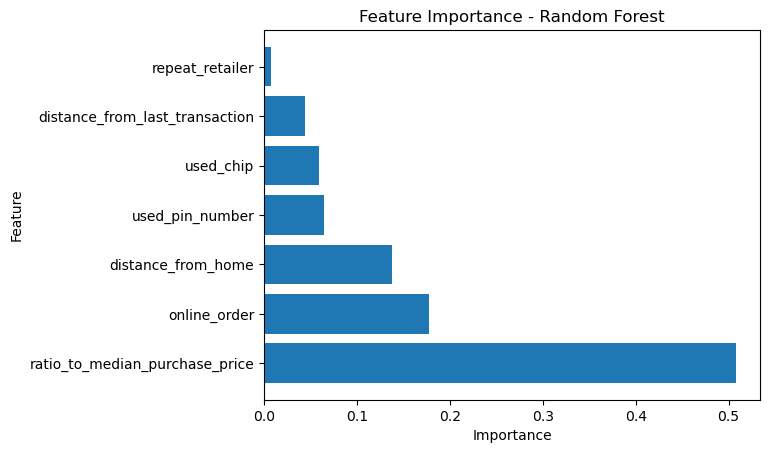

In [20]:
# Create a DataFrame with the feature importance
df_feature_importance_rf = pd.DataFrame({'Feature': X_train.columns, 'Importance': clf_rf.feature_importances_})
df_feature_importance_rf = df_feature_importance_rf.sort_values('Importance', ascending=False)

# Plot the feature importance
plt.barh(df_feature_importance_rf['Feature'], df_feature_importance_rf['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - Random Forest')
plt.show()

Somewhat surprisingly, XGBoost seems to have picked up on different features than the Decision Tree and Random Forest models. The most important feature is `online_order`, followed by  `ratio_to_median_purchase_price` as you can see from the plot below

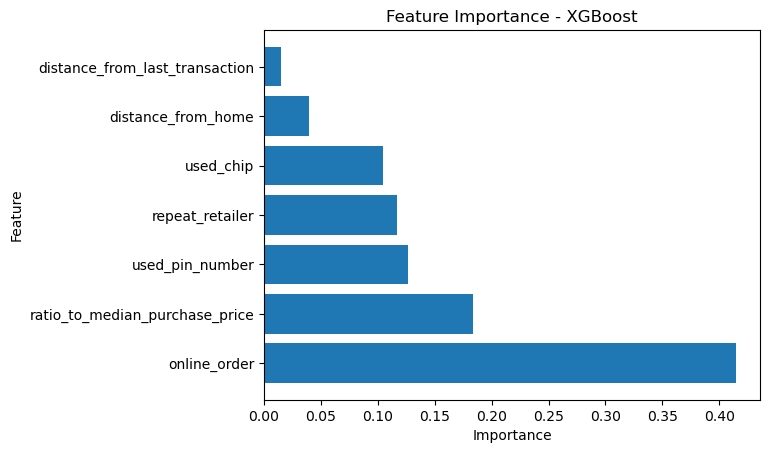

In [21]:
# Create a DataFrame with the feature importance
df_feature_importance_xgb = pd.DataFrame({'Feature': X_train.columns, 'Importance': clf_xgb.feature_importances_})
df_feature_importance_xgb = df_feature_importance_xgb.sort_values('Importance', ascending=False)

# Plot the feature importance
plt.barh(df_feature_importance_xgb['Feature'], df_feature_importance_xgb['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - XGBoost')
plt.show()

### Permuation Importance

We can also look at the permutation importance of each model. The permutation importance is a measure of how much each feature contributes to the model's predictions. The permutation importance is calculated by permuting the values of each feature and measuring how much the model's performance decreases. Let's start with the Decision Tree model

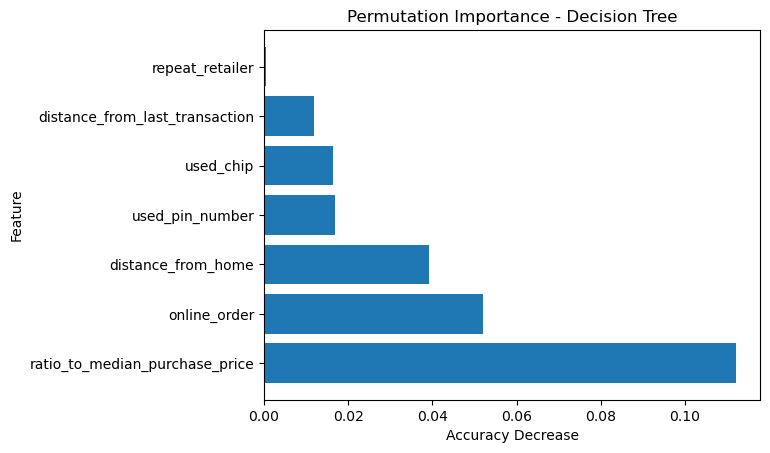

In [22]:
# Calculate the permutation importance
result_dt = permutation_importance(clf_dt, X_test, y_test, n_repeats=10, random_state=0)

# Create a DataFrame with the permutation importance
df_permutation_importance_dt = pd.DataFrame({'Feature': X_train.columns, 'Importance': result_dt.importances_mean})
df_permutation_importance_dt = df_permutation_importance_dt.sort_values('Importance', ascending=False)

# Plot the permutation importance
plt.barh(df_permutation_importance_dt['Feature'], df_permutation_importance_dt['Importance'])
plt.xlabel('Accuracy Decrease')
plt.ylabel('Feature')
plt.title('Permutation Importance - Decision Tree')
plt.show()

Let's also look at the permutation importance of the Random Forest model

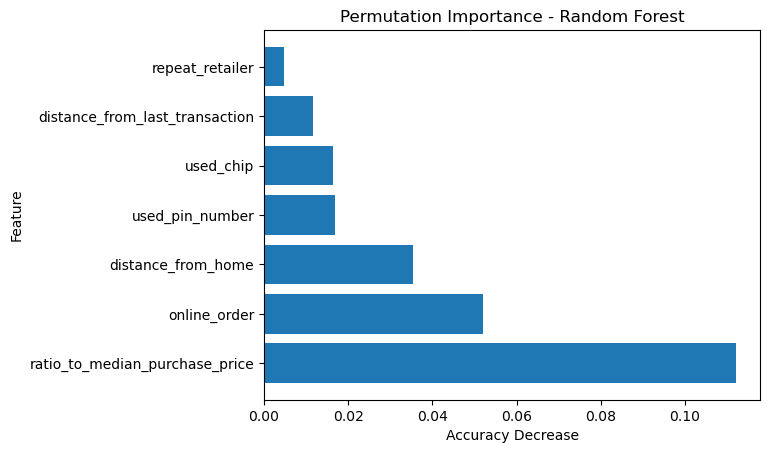

In [23]:
# Calculate the permutation importance
result_rf = permutation_importance(clf_rf, X_test, y_test, n_repeats=10, random_state=0)

# Create a DataFrame with the permutation importance
df_permutation_importance_rf = pd.DataFrame({'Feature': X_train.columns, 'Importance': result_rf.importances_mean})
df_permutation_importance_rf = df_permutation_importance_rf.sort_values('Importance', ascending=False)

# Plot the permutation importance
plt.barh(df_permutation_importance_rf['Feature'], df_permutation_importance_rf['Importance'])
plt.xlabel('Accuracy Decrease')
plt.ylabel('Feature')
plt.title('Permutation Importance - Random Forest')
plt.show()

Let's also look at the permutation importance of the XGBoost model

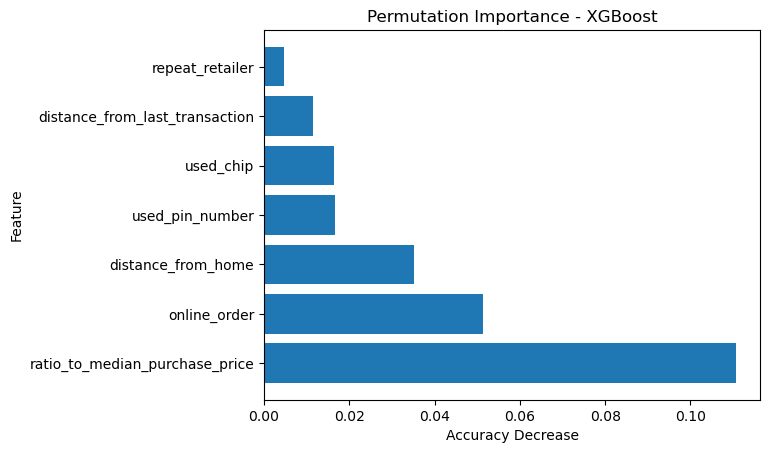

In [24]:
# Calculate the permutation importance
result_xgb = permutation_importance(clf_xgb, X_test, y_test, n_repeats=10, random_state=0)

# Create a DataFrame with the permutation importance
df_permutation_importance_xgb = pd.DataFrame({'Feature': X_train.columns, 'Importance': result_xgb.importances_mean})
df_permutation_importance_xgb = df_permutation_importance_xgb.sort_values('Importance', ascending=False)

# Plot the permutation importance
plt.barh(df_permutation_importance_xgb['Feature'], df_permutation_importance_xgb['Importance'])
plt.xlabel('Accuracy Decrease')
plt.ylabel('Feature')
plt.title('Permutation Importance - XGBoost')
plt.show()

Here the results for the three models are quite similar. The most important feature is `ratio_to_median_purchase_price`, followed by `online_order`.


### Conclusions

In this notebook, we have seen how to implement decision trees, random forests, and XGBoost classifiers in Python. We have also seen how to evaluate the performance of these models using metrics such as accuracy, precision, recall, and ROC AUC. We have seen that the Random Forest and XGBoost models perform better than the Decision Tree model. Furthermore, we looked at the feature and permutation importance of each model to see which features are most important for determining whether a transaction is fraudulent or not.
